# Experiments with Multi Scale Entropy for Unsupervised Classification

Reference: https://arxiv.org/abs/2206.13529

## Imports

In [58]:
import pickle
import george
import scipy
import sncosmo

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy.units as u
import astropy.constants as c

from pyentrp import entropy as ent
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from astropy.io import ascii
from matplotlib.ticker import LinearLocator
from matplotlib import cm

In [2]:
lc_optical = pd.read_table('2011fe_LC.ascii', sep='\t', comment='#')

# Replaces dumb names
lc_optical.rename(columns={'JD^a': 'JD'}, inplace=True)
lc_optical.rename(columns={'Phase^b': 'Phase'}, inplace=True)
lc_optical.rename(columns={'U (mag)^c': 'U_mag'}, inplace=True)
lc_optical.rename(columns={'B (mag)': 'B_mag'}, inplace=True)
lc_optical.rename(columns={'V (mag)': 'V_mag'}, inplace=True)
lc_optical.rename(columns={'R (mag)': 'R_mag'}, inplace=True)
lc_optical.rename(columns={'I (mag)': 'I_mag'}, inplace=True)
lc_optical.drop(columns='Unnamed: 8', inplace=True)

lc_optical

,JD,Phase,U_mag,B_mag,V_mag,R_mag,I_mag,Telescope
0,5798.17,-16.31,15.013(086),15.185(030),14.797(021),14.740(020),14.848(030),KAIT
1,5798.53,-15.95,14.534(014),14.743(013),14.325(019),14.260(024),14.248(052),LJT
2,5799.16,-15.32,13.894(044),14.027(030),13.685(020),13.641(020),13.745(030),KAIT
3,5799.53,-14.95,13.572(036),13.687(019),13.410(020),13.367(025),13.333(040),LJT
4,5800.17,-14.31,13.138(084),13.225(030),12.943(020),12.921(020),12.991(030),KAIT
...,...,...,...,...,...,...,...,...
114,6090.72,276.24,cdots,16.588(034),16.673(033),17.399(077),16.709(088),TNT
115,6108.53,294.05,cdots,17.318(139),17.234(082),17.850(117),16.937(061),TNT
116,6137.54,323.06,cdots,17.651(101),17.430(071),18.258(090),17.145(059),TNT
117,6160.59,346.11,cdots,17.918(140),17.814(107),18.051(155),18.096(260),TNT


In [3]:
lc_ir = pd.read_table('IR.txt', sep='\t', comment='#')

# Replaces dumb names
lc_ir['JD'] = lc_ir['MJD'] - 50000.5
lc_ir.rename(columns={'J': 'J_mag'}, inplace=True)
lc_ir.rename(columns={'H': 'H_mag'}, inplace=True)
lc_ir.rename(columns={'K_s': 'K_mag'}, inplace=True)
lc_ir.drop(columns=['MJD','Unnamed: 4'], inplace=True)

lc_ir

,J_mag,H_mag,K_mag,JD
0,12.860 (010),12.822 (009),12.855 (031),5799.621
1,11.901 (010),11.898 (008),11.967 (029),5801.668
2,11.566 (011),11.587 (008),11.609 (012),5802.621
3,...,11.317 (010),...,5803.695
4,...,11.124 (008),...,5804.699
5,10.685 (013),10.849 (008),10.809 (014),5806.648
6,10.583 (010),10.768 (008),10.720 (011),5807.602
7,10.503 (009),10.804 (008),10.641 (013),5812.613
8,10.968 (009),11.028 (008),10.890 (012),5818.633
9,11.072 (009),11.036 (008),10.912 (011),5819.590


In [4]:
lc_uv = ascii.read('swift.txt').to_pandas()
lc_uv = lc_uv[np.isnan(lc_uv['mag'])==False]

# Replaces dumb names
lc_uv['JD'] = lc_uv['MJD'] - 50000.5
lc_uv.drop(columns=['Upper','CRate','e_CRate','Flux','e_Flux'], inplace=True)
lc_uv.rename(columns={'Filter': 'Band'}, inplace=True)
lc_uv.rename(columns={'e_mag': 'mag_err'}, inplace=True)
lc_uv.drop(columns='MJD', inplace=True)
lc_uv['Band'] = [a.upper() for a in lc_uv['Band']]

lc_uv = lc_uv[lc_uv['mag'] > 5]

lc_uv

,Band,mag,mag_err,JD
2,UVW2,17.53,0.16,5798.5045
3,UVW2,17.59,0.15,5798.6339
4,UVW2,17.46,0.14,5798.7115
5,UVW2,17.42,0.14,5798.9016
6,UVW2,17.29,0.12,5799.0407
...,...,...,...,...
1027,V,13.45,0.04,5901.0399
1028,V,13.50,0.04,5903.2387
1029,V,13.53,0.04,5904.5753
1030,V,13.61,0.04,5909.4551


In [5]:
optical_bands = ['U', 'B', 'V', 'R', 'I']
ir_bands = ['J', 'H', 'K']
uv_band = [a.upper() for a in np.unique(lc_uv['Band'])]
bands = list(set(optical_bands + ir_bands + uv_band))
bands

['K', 'U', 'V', 'I', 'J', 'UVW1', 'UVM2', 'R', 'UVW2', 'B', 'H']

In [6]:
# In A
wavelengths = {
    'U': 3663,
    'B': 4361,
    'V': 5448,
    'R': 6407,
    'I': 7980,
    'J': 12200,
    'H': 16300,
    'K': 21900,
    'UVM2': 2310,
    'UVW1': 2910,
    'UVW2': 2120,
    
}

colors = {
    'U': 'purple',
    'B': 'blue',
    'V': 'green',
    'R': 'red',
    'I': 'pink',
    'J': 'orange',
    'H': 'black',
    'K': 'gray',
    'UVM2': 'cyan',
    'UVW1': 'brown',
    'UVW2': 'violet',
}

offsets = {
    'UVM2': -12,
    'UVW1': -8.5,
    'UVW2': -13,
    'U': -3.5,
    'B': 0,
    'V': 2,
    'R': 3.5,
    'I': 5,
    'J': 6.5,
    'H': 9,
    'K': 10,
}

In [7]:
formated_lc = []

# OPTICAL LIGHT CURVE
for i in range(len(lc_optical)):
    row = lc_optical.iloc[i]
    JD, telescope = row['JD'], row['Telescope']
    for band in optical_bands:
        
        m = row[f'{band}_mag']
        m_split = m.split('(')
        
        # Make sure there is some real value
        if m_split != ['cdots']:
            
            mag, mag_err = m_split
            mag = float(mag)
            mag_err = float("0."+mag_err[:-1])
            effective_wavelength = wavelengths[band]
            
            d = {
                'JD': JD,
                'Band': band,
                'mag': mag,
                'mag_err': mag_err,
                'effective_wavelength': effective_wavelength,
            }
            
            temp_df = pd.DataFrame([d])
            formated_lc.append(temp_df)

# IR LIGHT CURVE
for i in range(len(lc_ir)):
    row = lc_ir.iloc[i]
    JD = row['JD']
    for band in ir_bands:
        
        m = row[f'{band}_mag']
        m_split = m.split(' (')
        
        # Make sure there is some real value
        if m_split != [' ... ']:
            
            mag, mag_err = m_split
            mag = float(mag)
            mag_err = float("0."+mag_err[:-1])
            effective_wavelength = wavelengths[band]
            
            d = {
                'JD': JD,
                'Band': band,
                'mag': mag,
                'mag_err': mag_err,
                'effective_wavelength': effective_wavelength,
            }
            
            temp_df = pd.DataFrame([d])
            formated_lc.append(temp_df)

# UV LIGHT CURVE
lc_uv['effective_wavelength'] = [wavelengths[a] for a in lc_uv['Band']]
formated_lc.append(lc_uv)
            
formated_lc = pd.concat(formated_lc, ignore_index=True)
formated_lc.sort_values('JD', inplace=True)

# Code to remove the last three observations which cause uncertainties to blow up
#formated_lc = formated_lc.iloc[:-3]

formated_lc

,JD,Band,mag,mag_err,effective_wavelength
1143,5797.4237,UVW1,17.490,0.140,2910
1328,5797.4252,U,15.780,0.070,3663
1480,5797.4261,B,15.660,0.060,4361
1558,5797.4309,V,15.270,0.060,5448
1144,5797.4906,UVW1,17.230,0.130,2910
...,...,...,...,...,...
553,6160.5900,R,18.051,0.155,6407
554,6160.5900,I,18.096,0.260,7980
555,6277.5600,V,19.360,0.040,5448
557,6277.5600,I,18.930,0.030,7980


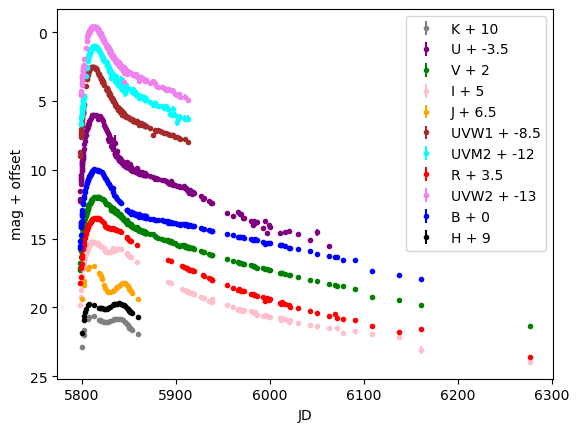

In [8]:
for i, band in enumerate(bands):
    
    offset = offsets[band]
    
    df_pb = formated_lc[formated_lc['Band']==band]
    
    marker_color = colors[band]
    time = df_pb['JD']
    mag = df_pb['mag']
    mag_err = df_pb['mag_err']
    
    plt.errorbar(time, mag + offset, yerr=mag_err, fmt='.', label=f"{band} + {offset}", color=marker_color)

plt.gca().invert_yaxis()
plt.legend()

plt.xlabel('JD')
plt.ylabel('mag + offset')

plt.ion()

## GP with Skelearn

In [9]:
mag = formated_lc['mag'].to_numpy()
mag_err = formated_lc['mag_err'].to_numpy()
jd = formated_lc['JD'].to_numpy()
wavelength = formated_lc['effective_wavelength'].to_numpy()

def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(mag)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(mag)

all_times = np.linspace(min(jd), max(jd), 1000)
kernel = Matern(length_scale=[100, 1000], nu=0.2)

gp = GaussianProcessRegressor(kernel=kernel, alpha=mag_err**2).fit(np.array([jd, wavelength]).T, mag)

/Users/vedshah/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Text(0, 0.5, 'mag + offset')

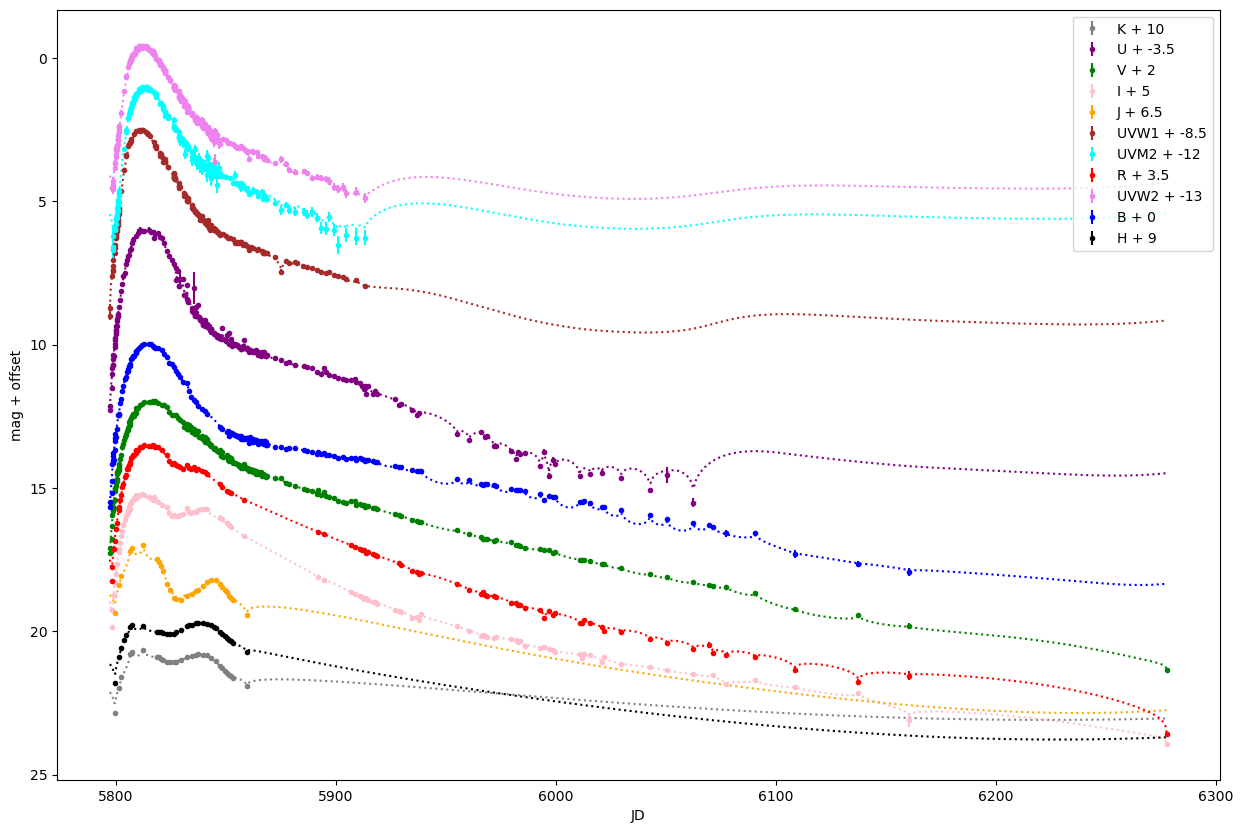

In [10]:
plt.figure(figsize=[15, 10])
for i, band in enumerate(bands):
    
    offset = offsets[band]
    
    effective_wavelength = wavelengths[band]
    df_pb = formated_lc[formated_lc['Band']==band]
    
    marker_color = colors[band]
    jd = df_pb['JD'].to_numpy()
    mag = df_pb['mag'].to_numpy()
    mag_err = df_pb['mag_err'].to_numpy()
    
    pred, pred_var = gp.predict(np.array([all_times, [effective_wavelength]*len(all_times)]).T, return_std=True)

    
    plt.errorbar(jd, mag + offset, yerr=mag_err, fmt='.', label=f"{band} + {offset}", color=marker_color)
    plt.plot(all_times, pred + offset, color=marker_color, linestyle='dotted')
    #plt.fill_between(all_times, y1=pred+pred_var+offset, y2=pred-pred_var+offset, alpha=0.2, color=marker_color)

plt.legend()
plt.gca().invert_yaxis()
plt.legend()

plt.xlabel('JD')
plt.ylabel('mag + offset')

In [44]:
# Create the SED

all_times = np.arange(min(formated_lc['JD']), max(formated_lc['JD']) + 1, 1)
all_wavelengths = np.arange(wavelengths['UVW2'], wavelengths['K'], 3)

x = []
y = []
for t in all_times:
    
    x_temp = np.array([[t]*len(all_wavelengths), all_wavelengths]).T
    pred, pred_var = gp.predict(x_temp, return_std=True)
    
    x.append(x_temp)
    y.append(pred)

# Stack all times and wavelengths 
x = np.vstack(x)
y = np.vstack(y)
#print(x)


print(y)

[[17.10997971 17.12201049 17.13338207 ... 12.12214546 12.12237797
  12.12235728]
 [17.34912231 17.35404298 17.34856928 ... 12.25195939 12.25299681
  12.25334569]
 [16.91279123 16.92623274 16.93676938 ... 12.50849761 12.5266172
  12.53630912]
 ...
 [17.36657287 17.36766699 17.36876148 ... 13.0466347  13.04584876
  13.04506292]
 [17.35865175 17.35974558 17.36083979 ... 13.04476829 13.0439828
  13.04319739]
 [17.350546   17.35163932 17.35273301 ... 13.04286801 13.04208296
  13.04129801]]


In [45]:
y = np.array(y)
y = np.hstack(y)

In [46]:
sed_mag = pd.DataFrame(x, columns=['Time','Effective Wavelength'])
sed_mag['mag'] = y
sed_mag['flux'] = ((y*u.ABmag).to(u.erg/u.s/u.cm**2/u.Hz) * c.c/(x[:,1]*u.AA)**2).to(u.erg/u.s/u.cm**2/u.AA).value
sed_mag

,Time,Effective Wavelength,mag,flux
0,5797.4237,2120.0,17.109980,3.468623e-15
1,5797.4237,2123.0,17.122010,3.420712e-15
2,5797.4237,2126.0,17.133382,3.375525e-15
3,5797.4237,2129.0,17.144108,3.332929e-15
4,5797.4237,2132.0,17.154213,3.292769e-15
...,...,...,...,...
3178303,6278.4237,21887.0,13.044438,1.376172e-15
3178304,6278.4237,21890.0,13.043653,1.376791e-15
3178305,6278.4237,21893.0,13.042868,1.377409e-15
3178306,6278.4237,21896.0,13.042083,1.378028e-15


In [47]:
sed_mag = sed_mag.drop(columns=['mag'])
sed_mag.to_csv("2011fe.csv")

In [48]:
sed_mag.sort_values(by=['Time', 'Effective Wavelength'])

,Time,Effective Wavelength,flux
0,5797.4237,2120.0,3.468623e-15
1,5797.4237,2123.0,3.420712e-15
2,5797.4237,2126.0,3.375525e-15
3,5797.4237,2129.0,3.332929e-15
4,5797.4237,2132.0,3.292769e-15
...,...,...,...
3178303,6278.4237,21887.0,1.376172e-15
3178304,6278.4237,21890.0,1.376791e-15
3178305,6278.4237,21893.0,1.377409e-15
3178306,6278.4237,21896.0,1.378028e-15


In [49]:
flux_grid =np.zeros([len(all_times), len(all_wavelengths)])

for i, t in enumerate(all_times):
    
    flux_grid[i, :] = sed_mag[sed_mag['Time']==t]['flux']
    
flux_grid.shape, all_times.shape, all_wavelengths.shape

((482, 6594), (482,), (6594,))

In [50]:
sed = sncosmo.TimeSeriesSource(wave=all_wavelengths, flux=flux_grid, phase=all_times)
all_times, sed.bandmag(band='lsstr', phase=all_times, magsys="ab")

(array([5797.4237, 5798.4237, 5799.4237, 5800.4237, 5801.4237, 5802.4237,
        5803.4237, 5804.4237, 5805.4237, 5806.4237, 5807.4237, 5808.4237,
        5809.4237, 5810.4237, 5811.4237, 5812.4237, 5813.4237, 5814.4237,
        5815.4237, 5816.4237, 5817.4237, 5818.4237, 5819.4237, 5820.4237,
        5821.4237, 5822.4237, 5823.4237, 5824.4237, 5825.4237, 5826.4237,
        5827.4237, 5828.4237, 5829.4237, 5830.4237, 5831.4237, 5832.4237,
        5833.4237, 5834.4237, 5835.4237, 5836.4237, 5837.4237, 5838.4237,
        5839.4237, 5840.4237, 5841.4237, 5842.4237, 5843.4237, 5844.4237,
        5845.4237, 5846.4237, 5847.4237, 5848.4237, 5849.4237, 5850.4237,
        5851.4237, 5852.4237, 5853.4237, 5854.4237, 5855.4237, 5856.4237,
        5857.4237, 5858.4237, 5859.4237, 5860.4237, 5861.4237, 5862.4237,
        5863.4237, 5864.4237, 5865.4237, 5866.4237, 5867.4237, 5868.4237,
        5869.4237, 5870.4237, 5871.4237, 5872.4237, 5873.4237, 5874.4237,
        5875.4237, 5876.4237, 5877.423

In [51]:
formated_lc[formated_lc['Band']=='R'].sort_values(by='JD')

,JD,Band,mag,mag_err,effective_wavelength
3,5798.17,R,14.740,0.020,6407
8,5798.53,R,14.260,0.024,6407
13,5799.16,R,13.641,0.020,6407
18,5799.53,R,13.367,0.025,6407
23,5800.17,R,12.921,0.020,6407
...,...,...,...,...,...
541,6090.72,R,17.399,0.077,6407
545,6108.53,R,17.850,0.117,6407
549,6137.54,R,18.258,0.090,6407
553,6160.59,R,18.051,0.155,6407


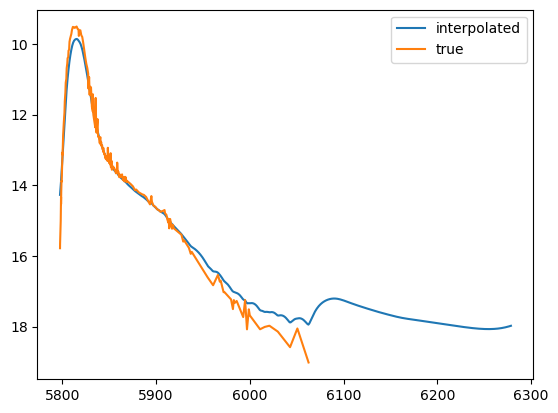

In [68]:
plt.plot(all_times, sed.bandmag(band='lsstu', phase=all_times, magsys="ab"), label='interpolated')
plt.plot(formated_lc[formated_lc['Band']=='U'].sort_values(by='JD')['JD'], formated_lc[formated_lc['Band']=='U'].sort_values(by='JD')['mag'], label='true')
plt.legend()
plt.gca().invert_yaxis()

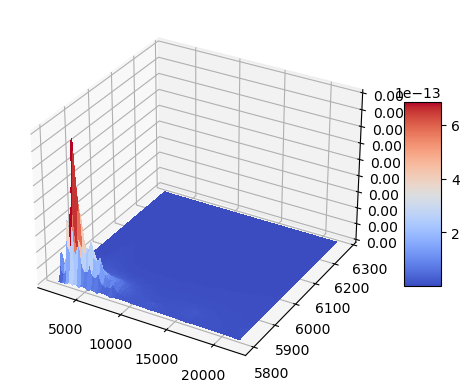

In [64]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = all_wavelengths
Y = all_times
X, Y = np.meshgrid(X, Y)
Z = flux_grid

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

Optimize for the amplitude of the factor, and the scalin factors for the time and wavelenth and the mean function.

## With George

In [310]:
mag = formated_lc['mag'].to_numpy()
mag_err = formated_lc['mag_err'].to_numpy()
jd = formated_lc['JD'].to_numpy()
wavelength = formated_lc['effective_wavelength'].to_numpy()
gp_mags = mag - 21

def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(mag)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(mag)

all_times = np.linspace(min(jd), max(jd), 10000)

signal_to_noises = np.abs(mag) / np.sqrt(
    mag_err ** 2 + (1e-2 * np.max(mag)) ** 2
)
scale = np.abs(mag[signal_to_noises.argmax()])

kernel = (0.2)**2 * george.kernels.Matern32Kernel(
    [100**2, 5000**2], ndim=2
)


kernel = np.var(gp_mags) * george.kernels.ExpSquaredKernel([5, 1000], ndim=2)

gp = george.GP(kernel, mean=12.5)

gp.compute(np.array([jd, wavelength]).T, mag_err)
result = scipy.optimize.minimize(neg_ln_like,
                                 gp.get_parameter_vector(),
                                 jac=grad_neg_ln_like)
gp.set_parameter_vector(result.x)
print(result.x)

[1.42698368 3.73921095 6.90782993]


Text(0, 0.5, 'mag + offset')

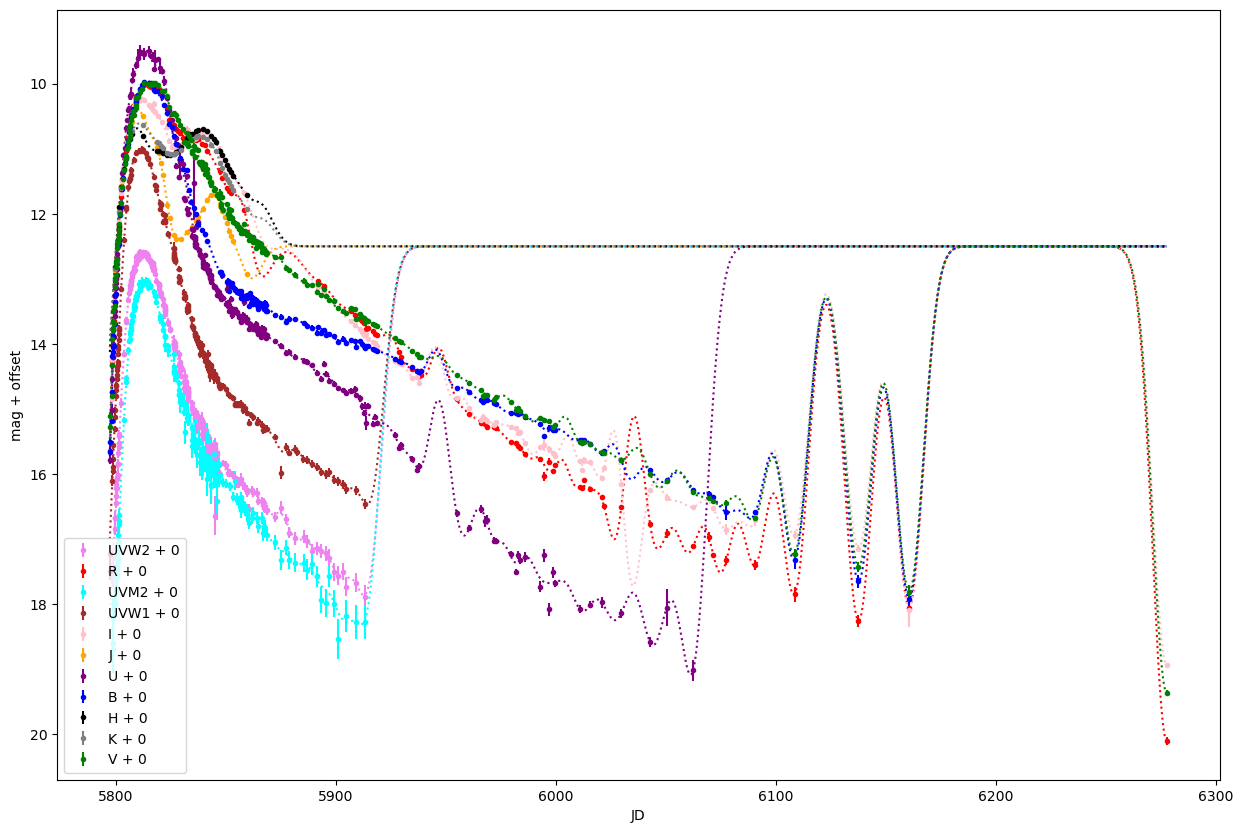

In [311]:
plt.figure(figsize=[15, 10])
for i, band in enumerate(bands):
    
    offset = 0
    
    effective_wavelength = wavelengths[band]
    df_pb = formated_lc[formated_lc['Band']==band]
    
    marker_color = colors[band]
    jd = df_pb['JD'].to_numpy()
    mag = df_pb['mag'].to_numpy()
    mag_err = df_pb['mag_err'].to_numpy()
    
    pred, pred_var = gp.predict(formated_lc['mag'], np.array([all_times, [effective_wavelength]*len(all_times)]).T, return_var=True)
    pred_std = pred_var**0.5

    
    plt.errorbar(jd, mag + offset, yerr=mag_err, fmt='.', label=f"{band} + {offset}", color=marker_color)
    plt.plot(all_times, pred + offset, color=marker_color, linestyle='dotted')
    #plt.fill_between(all_times, y1=pred+pred_std+offset, y2=pred-pred_std+offset, alpha=0.2, color=marker_color)
    #plt.fill_between(all_times, y1=pred+2*pred_std+offset, y2=pred-2*pred_std+offset, alpha=0.2, color=marker_color)

plt.legend()
plt.gca().invert_yaxis()
plt.legend()

#plt.xlim(5780, 6170)

plt.xlabel('JD')
plt.ylabel('mag + offset')